<br> <b>Rajput</b>, Rehan Razzaque 
<br> <b>Hmaied</b>, Oumaima

# Large-scale Distributed $k$-means Algorithm

In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


# Libraries used



#### Preamble code

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
import time

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [19]:
X, y = make_blobs(n_samples = 500, centers = 4,
                  random_state = 0, cluster_std = 0.6)

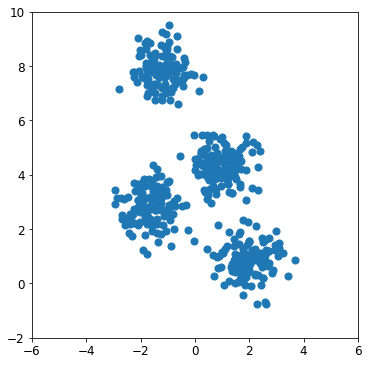

In [20]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Part 1.</strong> Implement our own version of k-means, as a serial algorithm.

Tasks:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget allocated to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, we generate input data according to the cell above, that uses scikitlearn.
<br>

The output of our cell contains the following information:
<ul>
    <li> The number of data points that belong to each cluster</li>
    <li> Plots the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [21]:
import random

In [23]:
def KMeans_user(X, k, maxiter, seed=None):
    
    # randomly choose k data points as initial centroids
    n_row, n_col = X.shape
    rand_indices = np.random.choice(n_row, size = k)
    centroids = X[rand_indices]
    # To store the value of centroids when it updates
    new_centroids = np.zeros(centroids.shape) 
    iter_centroids = [centroids]
    for itr in range(maxiter):
        # compute the distance matrix between each data point and the set of centroids
        distances_matrix = pairwise_distances(X, centroids, metric = 'sqeuclidean')
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distances_matrix, axis = 1)
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([X[cluster_assignment == i].mean(axis = 0) for i in range(k)])
        
        # STOP CONDITION
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        #keeping the track of the position of the centroids, for each iteration 
        iter_centroids.append(centroids)
    
    return centroids,cluster_assignment,iter_centroids


In [24]:
#Printing the number of data points that belong to each cluster
k=4
centroids,assignments,centroids_track = KMeans_user(X,k,10)
for i in np.arange(k):
    print("The number of clusters belonging to cluster %d is %d" % (i+1,np.sum(assignments==i)))

The number of clusters belonging to cluster 1 is 125
The number of clusters belonging to cluster 2 is 125
The number of clusters belonging to cluster 3 is 125
The number of clusters belonging to cluster 4 is 125


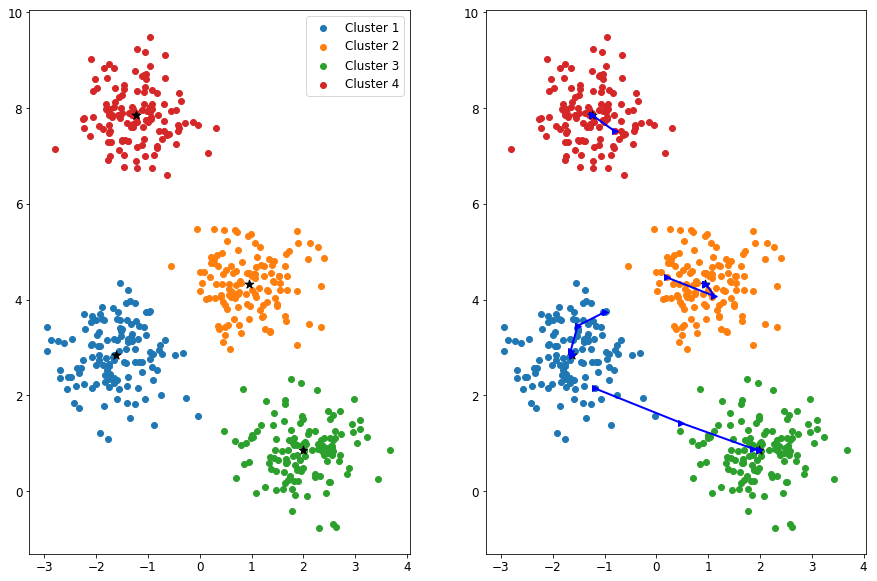

In [25]:
plt.figure(figsize=(15,10))
plt1 = plt.subplot(121)
#plot clusters 
for i in np.arange(k):
    plt1.scatter(X[np.where(assignments==i),0],X[np.where(assignments==i),1])
plt1.scatter(centroids[:,0],centroids[:,1],marker='*',color='black',s=80)
plt1.legend(["Cluster " + str(x+1) for x in np.arange(k)])
# Plot centroids direction
plt2 = plt.subplot(122)
centroids_track = np.array(centroids_track)
for i in np.arange(k):
    plt2.scatter(X[np.where(assignments==i),0],X[np.where(assignments==i),1])
    plt2.plot(centroids_track[:, i, 0], centroids_track[:, i, 1], 'b->', linewidth=2)
plt2.scatter(centroids[:,0],centroids[:,1],marker='*',color='black',s=80)

Looking at the figure on the right, we see that the centroids move a lot with respect to their initial positions. This happens because they're randomly initialized. Later on, we will see how the initial positions improve when we perform smart initialization.

<div class="alert alert-block alert-info">
<strong>Part 2.</strong> We use the built-in k-means implementation in sklearn and determine centroids and clusters.

Tasks:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of the cell contains the following information:
<ul>
    <li> Plots the clustered data points, using the same code we have produced for Part 1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [26]:
k=4
results = KMeans(k,max_iter=100,init='random').fit(X)

In [27]:
sk_centroids,sk_assignments = results.cluster_centers_,results.predict(X)

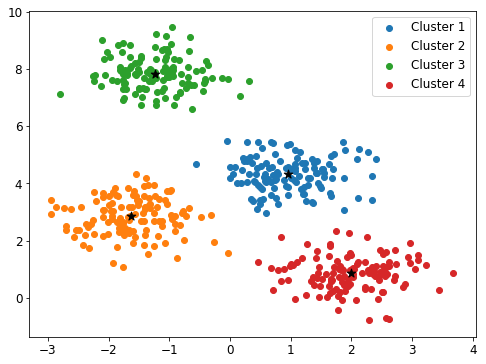

In [28]:
plt.figure()
for i in np.arange(k):
    plt.scatter(X[np.where(sk_assignments==i),0],X[np.where(sk_assignments==i),1])
plt.scatter(sk_centroids[:,0],sk_centroids[:,1],marker='*',color='black',s=80)
plt.legend(["Cluster " + str(x+1) for x in np.arange(k)])

***

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Part 3</strong> Modify our version of k-means, to compute heterogeneity as defined above.

Tasks:

<ul>
    <li>Use the same method template we used in Part 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [31]:
def KMeans_user_metric(X,k,iters,seed=None):
    
    centroids, clusters, c_track = KMeans_user(X, k, iters, seed)
    H = 0
    for j in np.arange(k):
        x_k = X[np.where(clusters==j),:][0]
        for i in np.arange(x_k.shape[0]):
            H += np.linalg.norm( x_k[i,:] - centroids[j,:] ,ord=2)
    
    return (centroids,clusters,c_track,H)

Heterogeneity value: 367.811556391
The number of clusters belonging to cluster 1 is 125
The number of clusters belonging to cluster 2 is 125
The number of clusters belonging to cluster 3 is 125
The number of clusters belonging to cluster 4 is 125


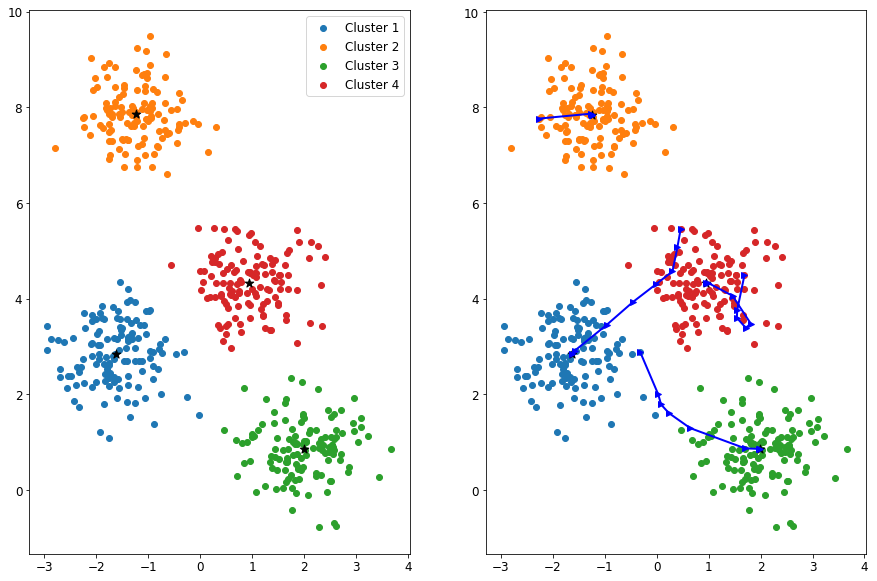

In [32]:
k=4
centroids,assignments,centroids_track,heterogeneity = KMeans_user_metric(X,k,10)
print('Heterogeneity value:', heterogeneity)
for i in np.arange(k):
    print("The number of clusters belonging to cluster %d is %d" % (i+1,np.sum(assignments==i)))
plt.figure(figsize=(15,10))
plt1 = plt.subplot(121)
#plot clusters 
for i in np.arange(k):
    plt1.scatter(X[np.where(assignments==i),0],X[np.where(assignments==i),1])
plt1.scatter(centroids[:,0],centroids[:,1],marker='*',color='black',s=80)
plt1.legend(["Cluster " + str(x+1) for x in np.arange(k)])
# Plot centroids direction
plt2 = plt.subplot(122)
centroids_track = np.array(centroids_track)
for i in np.arange(k):
    plt2.scatter(X[np.where(assignments==i),0],X[np.where(assignments==i),1])
    plt2.plot(centroids_track[:, i, 0], centroids_track[:, i, 1], 'b->', linewidth=2)
plt2.scatter(centroids[:,0],centroids[:,1],marker='*',color='black',s=80)

<div class="alert alert-block alert-info">
<strong>Part 4.</strong> Using the modified k-means method, we study algorithm convergence as a function of heterogeneity.

Tasks:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

A comment about the convergence properties of the $k$-means algorithm.

</div>

Heterogeneity values obtained:
	- with seed equals to  92.8675360373  heterogeneity is:	 367.811556391
	- with seed equals to  111.727654182  heterogeneity is:	 367.811556391
	- with seed equals to  214.361247857  heterogeneity is:	 367.811556391
	- with seed equals to  343.923960258  heterogeneity is:	 367.811556391
	- with seed equals to  451.921277612  heterogeneity is:	 567.137579331


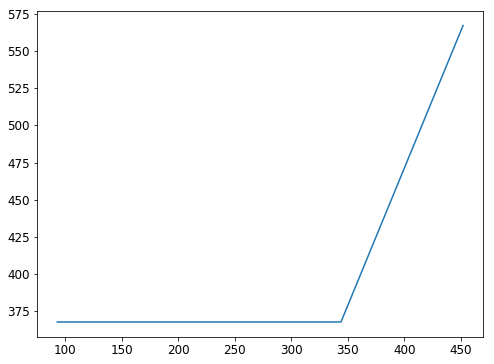

In [43]:
KM_rand_dict = {}
print('Heterogeneity values obtained:')
k=4
max_iter = 100
for i in np.arange(5):
    rand_seed = random.uniform(i*100,(i+1)*100)
    KM_rand_dict[rand_seed] = KMeans_user_metric(X,k,iters=max_iter,seed=rand_seed)[3]
    print('\t- with seed equals to ', rand_seed, ' heterogeneity is:\t', KM_rand_dict[rand_seed])
plt.figure()
plt.title
plt.plot(KM_rand_dict.keys(),KM_rand_dict.values())

# Comment about the convergence properties of the k-means algorithm:
As seen above, the heterogeneity value doesn't change with the seed value (save for the last seed value) and it remains the same for most of the seeds. This happens because the data is well clustered and there is just one global minima. Therefore, initial seed values do not have a large effect on the heterogeneity. However, if the data is not well clustered and there are many local minimas, initial seed values can have a lot of influence over the heterogeneity since the solution can get stuck in a local minima.

***

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm


<div class="alert alert-block alert-info">
<strong>Part 5.</strong> Modify our version of k-means, to introduce the smart initialization technique described above (keeping in mind the hetrogenity part).
<br>
<br>

Tasks:

<ul>
    <li>Use the same method template we used in Part 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [38]:
# this function compute the weight of each data point  
def dist_prob(X,centroid):
    #calculate the squared distance to the chosen centroid 
    prob = np.array([np.linalg.norm(X[i,:] - centroid,ord=2) for i in np.arange(len(X))])
    #normalizing the distance
    prob = prob/np.sum(prob)
    return np.array(prob)

In [39]:
def init_centroids(X,k,seed):
    lenx = len(X)
    #initialize the centroids
    centroids = []
    centroids.append(X[random.randrange(lenx),:])  # randomly choose 1 initial data point, for the first centroid
    for i in np.arange(1,k):
        #initialize the probability vector 
        prob = np.finfo(np.float32).max*np.ones(lenx)
        for j in np.arange(i):
            #for euach chosen centroid we compute the weight of each data point 
            prob = np.minimum(prob,dist_prob(X,centroids[j]))
        #choosing the next centroid as far as possible 
        centroids.append(X[np.argmax(prob),:])
    return np.array(centroids)           

In [40]:
def KMeans_plus_user_metric(X,k,iters,seed=None):
    centroids = init_centroids(X,k,None)
    # To store the value of centroids when it updates
    new_centroids = np.zeros(centroids.shape) 
    iter_centroids = [centroids]
    for itr in range(iters):
        # compute the distance matrix between each data point and the set of centroids
        distances_matrix = pairwise_distances(X, centroids, metric = 'sqeuclidean')
        # assign each data point to the closest centroid
        assignment = np.argmin(distances_matrix, axis = 1)
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([X[assignment == i].mean(axis = 0) for i in range(k)])
        
        # STOP CONDITION
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        #keeping the track of the position of the centroids, for each iteration 
        iter_centroids.append(centroids)
    H = 0
    for j in np.arange(k):
        x_k = X[np.where(assignment==j),:][0]
        for i in np.arange(x_k.shape[0]):
            H += np.linalg.norm( x_k[i,:] - centroids[j,:] ,ord=2)
    
    return (new_centroids,assignment,iter_centroids,H)

The heterogeneity is calculated to be : 367
	-The number of clusters belonging to cluster 1 is 125
	-The number of clusters belonging to cluster 2 is 125
	-The number of clusters belonging to cluster 3 is 125
	-The number of clusters belonging to cluster 4 is 125


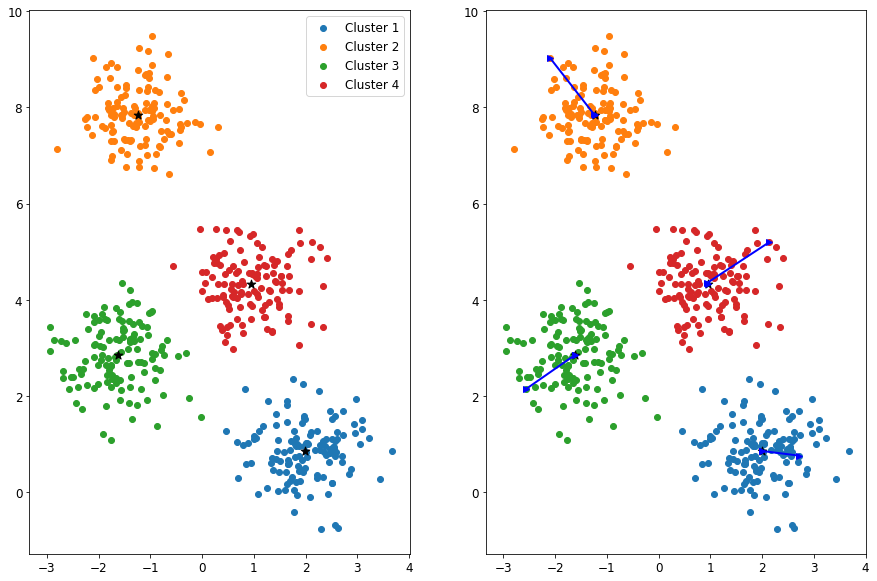

In [41]:
k=4
sm_centroids,sm_assignments,c_track,het = KMeans_plus_user_metric(X,k,100)
print("The heterogeneity is calculated to be : %d" % (het))
for i in np.arange(k):
    print("\t-The number of clusters belonging to cluster %d is %d" % (i+1,np.sum(sm_assignments==i)))

plt.figure(figsize=(15,10))
plt1 = plt.subplot(121)
for i in np.arange(k):
    plt1.scatter(X[np.where(sm_assignments==i),0],X[np.where(sm_assignments==i),1])
plt1.scatter(sm_centroids[:,0],sm_centroids[:,1],marker='*',color='black',s=80)
plt1.legend(["Cluster " + str(x+1) for x in np.arange(k)])
plt2 = plt.subplot(122)
c_track = np.array(c_track)
for i in np.arange(k):
    plt2.scatter(X[np.where(sm_assignments==i),0],X[np.where(sm_assignments==i),1])
    plt2.plot(c_track[:, i, 0], c_track[:, i, 1], 'b->', linewidth=2)
plt2.scatter(sm_centroids[:,0],sm_centroids[:,1],marker='*',color='black',s=80)

Looking at the figure on the right, we see that using the smart initialization method, the initial centroids were better positioned with respect to the random initialization.

<div class="alert alert-block alert-info">
<strong>Part 6.</strong> Similarly to question 5, using the modified k-means method, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. We add a comment to compare both of them.
</div>

Heterogeneity values obtained:
	- with seed equals to  41.7492358775  heterogeneity is:	 367.811556391
	- with seed equals to  184.357895038  heterogeneity is:	 367.811556391
	- with seed equals to  229.578462721  heterogeneity is:	 367.811556391
	- with seed equals to  342.132548531  heterogeneity is:	 367.811556391
	- with seed equals to  457.19574309  heterogeneity is:	 367.811556391


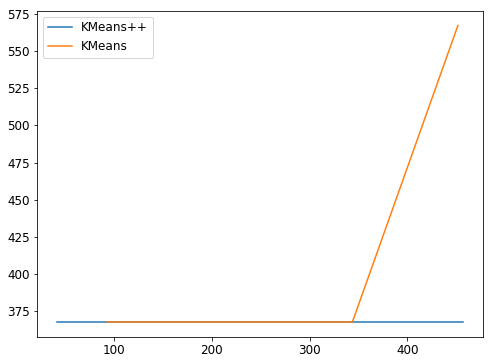

In [45]:
KMP_rand_dict = {}
print('Heterogeneity values obtained:')
k=4
max_iter = 100
for i in np.arange(5):
    rand_seed = random.uniform(i*100,(i+1)*100)
    KMP_rand_dict[rand_seed] = KMeans_plus_user_metric(X,k,iters=max_iter,seed=rand_seed)[3]
    print('\t- with seed equals to ', rand_seed, ' heterogeneity is:\t', KMP_rand_dict[rand_seed])
plt.figure()
plt.title
plt.plot(KMP_rand_dict.keys(),KMP_rand_dict.values())
plt.plot(KM_rand_dict.keys(),KM_rand_dict.values())
plt.legend(['KMeans++','KMeans'])

# Comment
Using the random seed values, the results in terms of heterogeneity of the K-Means++ algorithm should be better because the purpose of the K-Means++ algorithm was to mitigate the effects of the initial random centroid choice. As is clear from the above figure, the value for KMeans++ remains the same for all the seed values.

***

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Part 7.</strong> Using the k-means algorithm including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

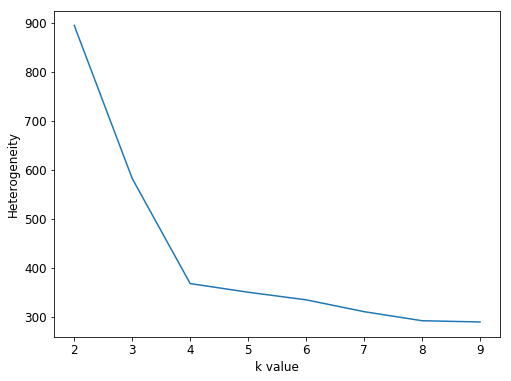

In [46]:
elbow_macaroni = []
max_iter = 100
for i in np.arange(2,10):
    elbow_macaroni.append(KMeans_plus_user_metric(X,i,iters=max_iter)[3])

    plt.xlabel('k value')
plt.ylabel('Heterogeneity')
plt.plot(np.arange(2,10),np.array(elbow_macaroni))

# comment 
Using the Elbow method, we noticed that the heterogeneity value decreases as the number of clusters increases. The optimum value for 'k' would be the value where the heterogeneity curve has its elbow. As clear from the above curve, the elbow of the curve is at k=4.

***

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

In [1]:
sc

<SparkContext master=spark://spark-master0-32833-prod:7077 appName=pyspark-shell>

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, we will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, we need to figure out how to implement the ```assignement_step``` function and the update_step function.

<div class="alert alert-block alert-info">
<strong>Part 8.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

The output cell contains:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>
</div>

In [47]:
X, y = make_blobs(n_samples = 500, centers = 4,
                  random_state = 0, cluster_std = 0.6)

In [57]:
def KMeans_distributed(X,k,max_iter):
    
    def distributed_assignment(iterator):
        # get the centroids
        centroids = cent_broadcast.value
        ret_list = []
        for point in list(iterator):
            choice = []
            # Iterate over all points of the partition
            for i in np.arange(len(centroids)):
                # compute the distance matrix between each data point and the set of centroids
                choice.append(np.linalg.norm(point - centroids[i,:]))
            #for each point, we choose the cluster which is the nearest
            #The item is a (key,value), where key is the cluster number and value is formatted as (point,1) <-- the final 1 will be used to calculate the average
            item = (np.argmin(np.array(choice)),(point,1))
            ret_list.append(item)
        return ret_list
    
    # Parallelize data
    # we can use the cache but in this particular context it's not recommended because our dataset is small 
    ps_X = sc.parallelize(X)#.cache()
    # randomly choose k data points as initial centroids
    n_row, n_col = X.shape
    rand_indices = np.random.choice(n_row, size = k)
    rand_centroids = X[rand_indices]
    # broadcast the centroids
    cent_broadcast = sc.broadcast(rand_centroids)
    
    for i in np.arange(max_iter):
        # all the workers apply distributed_assignement to all their partitions
        assignments = ps_X.mapPartitions(distributed_assignment)
        
        # Run distributed algorithm
        ## we reduce the the values of the same key in a way that <cluster_id,<sumOfPoints,numOfPoints>>
        cent_dist = assignments.reduceByKey(lambda a,b : (a[0] + b[0] , a[1]+b[1]))\
        .map(lambda a: a[1][0]/a[1][1] if(a[1][1] != 0) else 0).collect() ## the reduced result is mapped as follows: <cluster_id, sumOfPoints/numOfPoints>
        
        cent_dist = np.array(cent_dist)
        # Stop condition 
        if(np.array_equal(cent_dist,cent_broadcast.value)):
            break
        # broadcast the updated centroids
        cent_broadcast = sc.broadcast(cent_dist)
    
    return (assignments,cent_dist)

The centroid values: 
[[-1.62397851  2.84672953]
 [-1.23719873  7.85161617]
 [ 1.9896518   0.85486599]
 [ 0.94866739  4.33099426]]
CPU times: user 140 ms, sys: 24 ms, total: 164 ms
Wall time: 973 ms


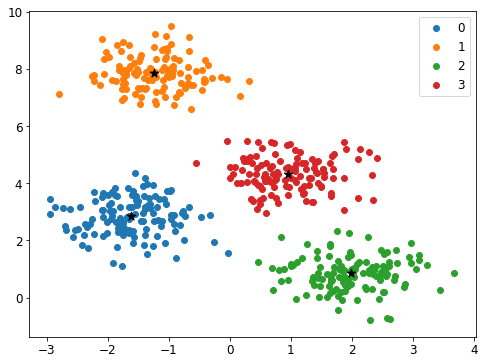

In [58]:
%%time
max_iter = 100
k=4
assignments,cent_dist = KMeans_distributed(X,k,max_iter)
print("The centroid values: " )
print(cent_dist)
assigned = assignments.mapValues(lambda a : a[0]).collect()
plt.figure()
for i in np.arange(len(cent_dist)):
    vals= np.array( [x[1] for x in assigned if x[0]==i] )
    plt.scatter(vals[:,0],vals[:,1])
plt.scatter(cent_dist[:,0],cent_dist[:,1],marker='*',color='black',s=80)
plt.legend(np.arange(len(cent_dist)))

<div class="alert alert-block alert-info">
<strong>Part 9.</strong> For someone who does not have access to the cloud specifications, we answer the following questions:

<ol><li><b>How many partitions did we use? Why?</b> The partitions with which we experimented, were all multiples of 6. Since, the number of total cores is 6. During the experiments we focused on two things: i.e. task computation time ratio and the total CPU-User time. <ul> <li>We realized that the CPU-User time remained minimal for only 6 partition and with the increasing number of partitions, CPU-User time increases.</li><li>The ratio of computation time of each task with respect to total time spent on task was maximum for 12 partitions. However, since the difference of the ratio between 6 and 12 partition was so small, we preferred to use the usual 6 partition since it's CPU-User time was small.</li></ul></li>
    <li><b>What is the size of the dataset we generate? Did we cache the dataset? What's the RAM occupation?</b> The size of our data is the same as the one used for serial algorithms (i.e. 300 points). The caching of data is important when the size of dataset is really big (order greater or equal to 10<sup>4</sup>). When answering question 11, we temporarily added the caching part to the distributed algorithm because we were testing it with a large amount of data. However, for a small amount of data caching rather slows down the process. The RAM occupation of the whole application is 18GB/21GB allocated.</li>
    <li><b>What is the size of the shuffle data over the network? How does it compare to the dataset size?</b>The shuffle data is 6.6KB for each job, when we use 6 partitions. The shuffle write and read data size increases with the increase in number of partitions. Changing the size of the dataset didn't show any change in the shuffle data size.</li></ol>

<div class="alert alert-block alert-info">
<strong>Task 10.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size we chose for our experiments, we need to find out:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>
    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
</ul>
</div>

To answer the first two questions of this part, we computed the cpu time of both the serial and distributed algorithms with the varying data size.

With regards to the third question. If the data resided on the disk, there would be no need to follow the <code>.parallelize(X)</code> step. Instead, we will directly read the file from the HDFS. If the data resided on the HDFS, it is not necessary that the data be divided into 6 partitions, because now the partitioning doesn't depend on the number of cores, but on the principle of data locality.

In [5]:
import time

In [13]:
k=4
iters = 100
max_size = 7
serial_time = {}
dist_time = {}
for i in np.arange(2,max_size):
    samp = np.power(10,i)
    X, y = make_blobs(n_samples = samp, centers = k,\
                  random_state = 0, cluster_std = 0.6)
    a = time.clock()
    
    KMeans_user(X,k,iters)
    
    b= time.clock()
    
    KMeans_distributed(X,k,iters)
    
    c= time.clock()
    
    serial_time[i] = b-a
    dist_time[i] = c-b

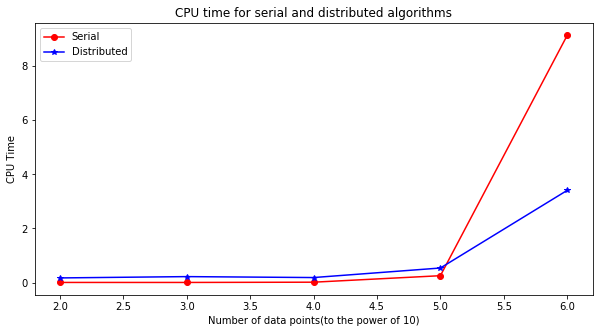

In [15]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(2,max_size),serial_time.values(),'-or')
plt.plot(np.arange(2,max_size),dist_time.values(),'-*b')
plt.title('CPU time for serial and distributed algorithms')
plt.xlabel('Number of data points(to the power of 10)')
plt.ylabel('CPU Time')
plt.legend(['Serial','Distributed'])

As is clear from the figures above, the serial algorithm generally performs better than the distributed algorithms for small amount of data (figure on the right). However, as the size of data increases, serial algorithms become drastically slow, whereas distributed algorithms perform faster. This can be seen when the data size is greater than 10<sup>5</sup>.